# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime as dt, timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import math
import json
import sys
import os

In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [7]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [8]:
%time userData = getUserInfo(prior_knowledge=True)

Wall time: 1min


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [9]:
userData = userData[userData['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [10]:
"Number of students:", len(userData)

('Number of students:', 214)

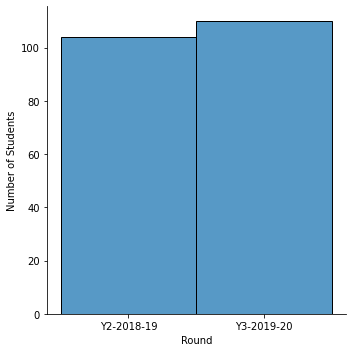

In [11]:
sns.displot(userData, x='Round')
plt.ylabel('Number of Students')
plt.show()

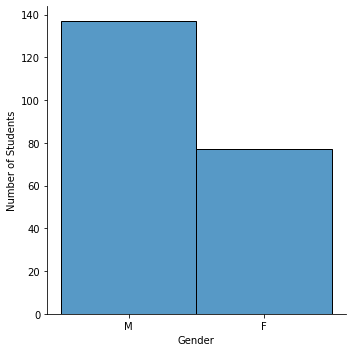

In [12]:
sns.displot(userData, x='Gender')
plt.ylabel('Number of Students')
plt.show()

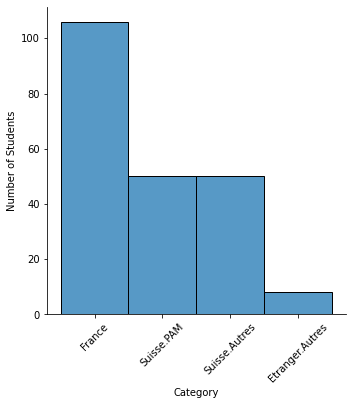

In [13]:
sns.displot(userData, x='Category')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

### Getting Students' Records

#### Video Clickstream Records

In [14]:
%time videoData = getVideoEventsInfo(mode='all')

Wall time: 1min 39s


In [15]:
videoData = videoData[videoData['Round'].isin(rounds)]

In [16]:
"Number of video events:", len(videoData)

('Number of video events:', 1416106)

#### Problem Clickstream Records

In [17]:
%time problemData = getProblemEventsInfo()

Wall time: 1min 8s


In [18]:
problemData = problemData[problemData['Round'].isin(rounds)]

In [19]:
"Number of problem events:", len(problemData)

('Number of problem events:', 473924)

#### Exam Records

In [20]:
%time examData = getExamInfo()

Wall time: 1min 6s


In [21]:
examData = examData[examData['Round'].isin(rounds)]

In [22]:
examData = examData[examData['AccountUserID'].isin(userData['AccountUserID'])]

In [23]:
"Number of graded students:", len(examData)

('Number of graded students:', 214)

#### Event Records

In [24]:
eventData = videoData.append(problemData)

In [25]:
eventData['Year'] = eventData['Round'].apply(lambda x: int(x.split('-')[1]))

#### Course Week Column

We get the configuration file (e.g, start and end date) for each round of the course. 

In [26]:
with open('../config/linear_algebra.json') as f:
    config = json.load(f)

We assign each video interaction to a specific week of the course, with the first week of the course round having id 0. 

In [27]:
eventData['Date'] = eventData['TimeStamp'].apply(lambda x:string2Datetime(dt.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

In [28]:
tmp_events = []
for r in rounds:
    round_events = eventData[eventData['Round'] == r]
    tmp_events.append(processWeek(round_events, 'Date', config[r.split('-')[-2]]['Start']))
eventData = pd.concat(tmp_events).copy()

In [29]:
eventData['Week'] = eventData['Week'].apply(lambda x: int(x))

Then, we filter only the first *noCourseWeeks* course weeks. 

In [30]:
eventData = eventData[eventData['Week'].isin(range(20))]

## * Cross validation of early warning systems *

#### Parameters

In [31]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 5, 15, 1
iterations = 3

In [32]:
weeks = np.arange(start + 1, end, step)

#### Feature Sets

In [ ]:
featureLabels = [AkpinarEtAl(), BoroujeniEtAl(), ChenCui(), HeEtAl(), LalleConati(), LemayDoleck()]

In [125]:
featureSets = loadFeatureSets(mode, task, ratio, start, end, step)

> Found features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


In [52]:
featureSets = computeFeatures(eventData, examData, featureLabels, featureSets, start, weeks)

> Set from week 5 : mbouzao_et_al ( 007 007 ) - Week: 14 ( 009 009 ) - User: 214 21414


In [73]:
saveFeatureSets(featureSets, mode, task, ratio, start, end, step)

> Saved features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


#### Models and Metrics

In [126]:
trainedModels = loadTrainedModels(mode, task, ratio, start, end, step)

> Initialized models for this experimental setting in ../data/trained_models/trained_models_random_binary_80_5-15-1.pkl


In [127]:
evaluationScores = {}
for i in range(iterations):
    print('Iteration', i)
    xTrain, xTest, yTrain, yTest = getTrainTestData(examData, mode, task, ratio / 100.0)
    
    classifiersTypes = {'ada': AdaBoostClassifier(), 'dt': DecisionTreeClassifier(), 'gnb': GaussianNB(), 'lr': LogisticRegression(), 'las': Lasso(), 'mlp': MLPClassifier(), 'knn': KNeighborsClassifier(), 'rf': RandomForestClassifier(), 'svm': SVC()}
    classifiersParams = {'ada': {'n_estimators': [25, 50, 100, 200], 'algorithm': ('SAMME', 'SAMME.R'), 'learning_rate': [0.1, 1]}, 'dt': {'criterion': ('gini', 'entropy'), 'splitter': ('best', 'random'), 'max_features': ('auto', 'sqrt', 'log2')}, 'gnb': {'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]}, 'lr': {'penalty': ('l1', 'l2', 'elasticnet', 'none'), 'tol': [1e-4, 1e-5], 'C': [1.0, 0.5], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 'multi_class': ('auto', 'ovr', 'multinomial')}, 'las': {'selection': ('cyclic', 'random'), 'tol': [1e-4, 1e-5], 'alpha': [0.5, 1.0, 1.5]}, 'mlp': {'activation': ('identity', 'logistic', 'tanh', 'relu'), 'solver': ('lbfgs', 'sgd', 'adam'), 'hidden_layer_sizes': [(8,), (16, 8), (32, 16, 8)]}, 'knn': {'n_neighbors': [5, 10, 50, 100], 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}, 'rf': {'n_estimators': [25, 50, 100, 200], 'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'sqrt', 'log2')}, 'svm': {'C': [1.0, 0.5], 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'gamma': ('scale', 'auto'), 'shrinking': (True, False)} }
    trainedModels, scaler = trainModels(featureSets, xTrain, yTrain, weeks, classifiersTypes, classifiersParams, trainedModels)
    
    evaluationMetrics = {'Acc': accuracy_score, 'F1': f1_score, 'P': precision_score, 'R': recall_score, 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp, 'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr, 'EER': eer }
    evaluationScores = computeMetrics(scaler, featureSets, trainedModels, xTest, yTest, evaluationMetrics, evaluationScores)

Iteration 0
> Binarizing student grades: [(0, 80), (1, 134)]
> Spitting the whole student population randomly: Train 171 [(0, 64), (1, 107)] - Test 43 [(0, 16), (1, 27)]
> Training on Set: lemay_doleck ( 006 006 ) - Week: 014 ( 009 009 ) - Algorithm: svm ( 009 009 )9 ) 004 009 ) he_et_al ( 004 006 ) - Week: 007 ( 002 009 ) - Algorithm: lr  ( 004 009 ) he_et_al ( 004 006 ) - Week: 010 ( 005 009 ) - Algorithm: lr  ( 004 009 ) he_et_al ( 004 006 ) - Week: 012 ( 007 009 ) - Algorithm: lr  ( 004 009 ) he_et_al ( 004 006 ) - Week: 013 ( 008 009 ) - Algorithm: lr  ( 004 009 ) lemay_doleck ( 006 006 ) - Week: 007 ( 002 009 ) - Algorithm: mlp ( 006 009 ) lemay_doleck ( 006 006 ) - Week: 008 ( 003 009 ) - Algorithm: gnb ( 003 009 )004 009 )
> Evaluated last iteration models
Iteration 1
> Binarizing student grades: [(0, 80), (1, 134)]
> Spitting the whole student population randomly: Train 171 [(0, 64), (1, 107)] - Test 43 [(0, 16), (1, 27)]
> Training on Set: lemay_doleck ( 006 006 ) - Week: 014

In [128]:
saveTrainedModels(trainedModels, mode, task, ratio, start, end, step)

> Saved models for this experimental setting in ../data/trained_models/trained_models_random_binary_80_5-15-1.pkl


## * Show and discuss the results *

In [129]:
lst_data = []
lst_name = []
for flabel in evaluationScores.keys():
    for wid in evaluationScores[flabel].keys():
        for mid in evaluationScores[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [np.mean(value) if i <=3 or i >=8 else np.around(np.mean(value)) for i, value in enumerate(evaluationScores[flabel][wid][mid].values())])  
            lst_name = ['week', 'set', 'clf'] + [emid for emid, _ in evaluationScores[flabel][wid][mid].items()]

In [130]:
df_results = pd.DataFrame(lst_data, columns = lst_name)

In [142]:
df_results[(df_results['week'] == 14) & (df_results['clf'] == 'mlp')].set_index(['week', 'set', 'clf'])

Acc        F1         P         R    TP    FN  \
week set             clf                                                       
14   akpinar_et_al   mlp  0.581395  0.639250  0.693651  0.617284  17.0  10.0   
     boroujeni_et_al mlp  0.635659  0.736830  0.667398  0.827160  22.0   5.0   
     chen_cui        mlp  0.651163  0.771333  0.655105  0.938272  25.0   2.0   
     he_et_al        mlp  0.612403  0.735977  0.639363  0.876543  24.0   3.0   
     lalle_conati    mlp  0.651163  0.766987  0.660977  0.913580  25.0   2.0   
     lemay_doleck    mlp  0.643411  0.774423  0.642886  0.975309  26.0   1.0   

                           TN    FP       TPR       TNR       FPR       FNR  \
week set             clf                                                      
14   akpinar_et_al   mlp  8.0   8.0  0.617284  0.520833  0.479167  0.382716   
     boroujeni_et_al mlp  5.0  11.0  0.827160  0.312500  0.687500  0.172840   
     chen_cui        mlp  3.0  13.0  0.938272  0.166667  0.833333  0.061728   
     he_et_al        mlp  3.0  13.0  0.876543  0.166667  0.833333  0.123457   
     lalle_conati    mlp  3.0  13.0  0.913580  0.208333  0.791667  0.086420   
     lemay_doleck    mlp  1.0  15.0  0.975309  0.083333  0.916667  0.024691   

                               EER  
week set             clf            
14   akpinar_et_al   mlp  0.430941  
     boroujeni_et_al mlp  0.430170  
     chen_cui        mlp  0.447531  
     he_et_al        mlp  0.478395  
     lalle_conati    mlp  0.439043  
     lemay_doleck    mlp  0.470679

In [177]:
def plot_metrics_per_model(df_results, weeks, emid, clf):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.title(clf)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 8)]
    
    for i, flabel in enumerate(np.unique(df_results['set'])):    
        df_features = df_results[df_results['set'] == flabel]
        
        for j, mid in enumerate(np.unique(df_features['clf'])): 
            if mid == clf:
                df_classifiers = df_features[df_features['clf'] == mid]
                plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[i], label=flabel)
            
    plt.ylim([0.5, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

In [187]:
def plot_metrics_per_feature(df_results, weeks, emid, flabel):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    df_features = df_results[df_results['set'] == flabel]

    plt.title(flabel)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 10)]

    for j, mid in enumerate(np.unique(df_features['clf'])): 
        df_classifiers = df_features[df_features['clf'] == mid]
        plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[j], label=mid)

    plt.axhline(y=.62, xmin=6, xmax=14, linestyle='--', color='red')    
        
    plt.ylim([0.5, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

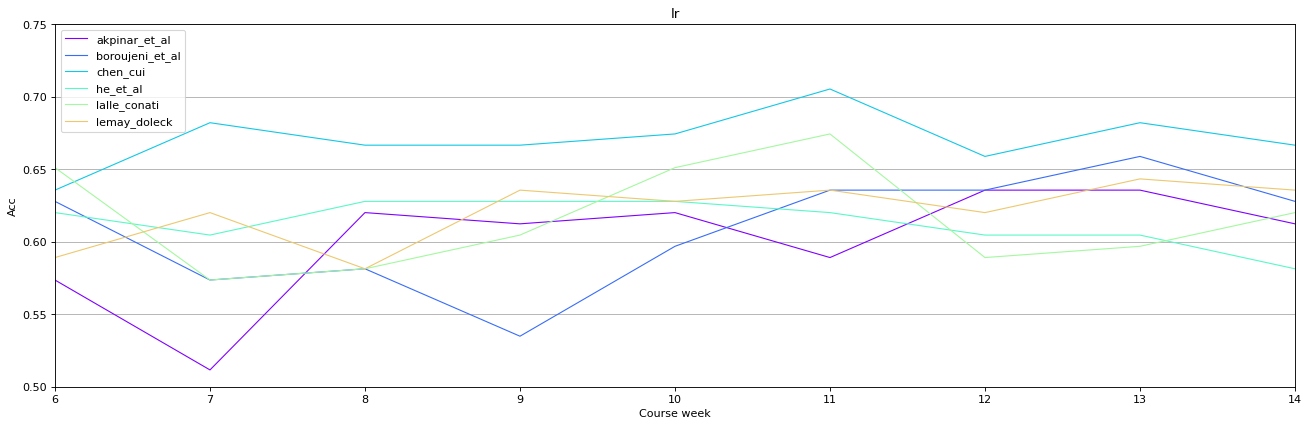

In [189]:
plot_metrics_per_model(df_results, weeks, 'Acc', 'lr')

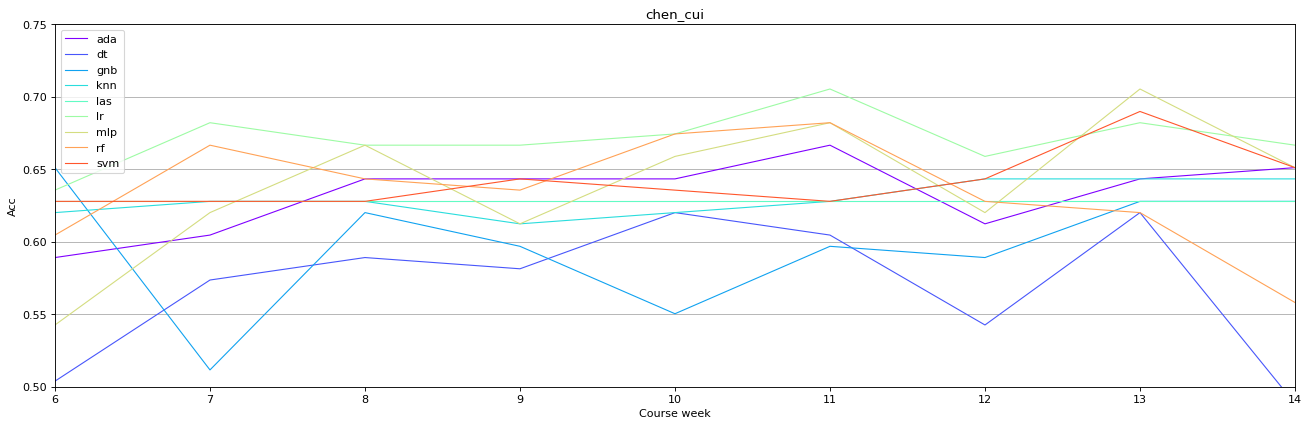

In [182]:
plot_metrics_per_feature(df_results, weeks, 'Acc', 'chen_cui')